# SliceFinder Demo

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from slice_finder import SliceFinder

from ipywidgets import interact, interactive
from IPython.display import display

from bokeh.layouts import widgetbox, row
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models.widgets import DataTable, TableColumn  
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 17})

Loading BokehJS ...


## Example: COMPAS dataset


In [2]:

data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed_7214rows_with_labels.csv"


compas_data = pd.read_csv(data_file)
selected_attributes = ["sex", "age_cat", "race", "ground_truth"]
compas_data = compas_data[selected_attributes]
compas_data[:5]


sex          age_cat              race  ground_truth
0  Male  Greater than 45             Other             0
1  Male          25 - 45  African-American             1
2  Male     Less than 25  African-American             1
3  Male     Less than 25  African-American             0
4  Male          25 - 45             Other             0

In [3]:



# # drop nan values
# adult_data = adult_data.dropna()

# Encode categorical features
encoders = {}
for column in compas_data.columns:
    if compas_data.dtypes[column] == np.object:
        le = LabelEncoder()
        compas_data[column] = le.fit_transform(compas_data[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X, y = compas_data[compas_data.columns.difference(["ground_truth"])], compas_data["ground_truth"]

pickle.dump(encoders, open("compas.pkl", "wb"), protocol=2)

# Train a model
#lr = LogisticRegression()
#lr.fit(X, y)
lr = RandomForestClassifier(max_depth=5, n_estimators=10)
lr.fit(X, y)

sf = SliceFinder(lr, (X, y))
metrics_all = sf.evaluate_model((X,y))
reference = (np.mean(metrics_all), np.std(metrics_all), len(metrics_all))




sex ['Female' 'Male'] [0 1]
age_cat ['25 - 45' 'Greater than 45' 'Less than 25'] [0 1 2]
race ['African-American' 'Asian' 'Caucasian' 'Hispanic' 'Native American'
 'Other'] [0 1 2 3 4 5]


In [5]:

# degree: number of att in a pattern
time1 = time.time()
recommendations = sf.find_slice(k=2, epsilon=0.4, degree=3, max_workers=4)
time2 = time.time()

print("time = {}s".format(time2 - time1))

for s in recommendations:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('---------------------\nmetric: %s'%(s.metric))
    print ('size: %s'%(s.size))



degree 1
crossing
effect size filtering
degree 2
crossing
effect size filtering
degree 3
crossing
effect size filtering
sorting
time = 28.561687231063843s

Slice description:
age_cat:Greater than 45 
race:Native American 
sex:Male 
---------------------
effect_size: 1.156563535179439
---------------------
metric: 1.059702127235708
size: 1

Slice description:
race:Native American 
age_cat:Greater than 45 
sex:Male 
---------------------
effect_size: 1.156563535179439
---------------------
metric: 1.059702127235708
size: 1


## Toy Example: UCI Census Data Set
For the demo, we use UCI Census data set and the classification task is to predict who makes above 50k a year.

In [2]:
adult_data = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

adult_data[:4]

Age         Workclass  fnlwgt  Education  Education-Num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   

       Martial Status         Occupation   Relationship   Race   Sex  \
0       Never-married       Adm-clerical  Not-in-family  White  Male   
1  Married-civ-spouse    Exec-managerial        Husband  White  Male   
2            Divorced  Handlers-cleaners  Not-in-family  White  Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black  Male   

   Capital Gain  Capital Loss  Hours per week        Country Target  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K

In [ ]:



# drop nan values
adult_data = adult_data.dropna()

# Encode categorical features
encoders = {}
for column in adult_data.columns:
    if adult_data.dtypes[column] == np.object:
        le = LabelEncoder()
        adult_data[column] = le.fit_transform(adult_data[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X, y = adult_data[adult_data.columns.difference(["Target"])], adult_data["Target"]

pickle.dump(encoders, open("encoders.pkl", "wb"), protocol=2)

# Train a model
#lr = LogisticRegression()
#lr.fit(X, y)
lr = RandomForestClassifier(max_depth=5, n_estimators=10)
lr.fit(X, y)

sf = SliceFinder(lr, (X, y))
metrics_all = sf.evaluate_model((X,y))
reference = (np.mean(metrics_all), np.std(metrics_all), len(metrics_all))

## SliceFinder Recommendation Example

In [3]:

recommendations = sf.find_slice(k=2, epsilon=0.4, degree=2, max_workers=4)

for s in recommendations:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('---------------------\nmetric: %s'%(s.metric))
    print ('size: %s'%(s.size))

degree 1
crossing
effect size filtering
sorting

Slice description:
Martial Status:Married-civ-spouse 
---------------------
effect_size: 0.6040000303351019
---------------------
metric: 0.5532719865804439
size: 14065

Slice description:
Relationship:Husband 
---------------------
effect_size: 0.5484750575275296
---------------------
metric: 0.5503098192568037
size: 12463


In [6]:
slices = list()
with open('slices.p','rb') as handle:
    slices = pickle.load(handle)

pickle.dump(slices, open('slices_ver2.pkl','wb'), protocol=2)

encoders = dict()
with open('encoder')

slices = list()
with open('slices_ver2.pkl','rb') as handle:
    slices = pickle.load(handle)
    
slices_ = sorted(slices, key=lambda s: s.size, reverse=True)    
k = 10    
for s in slices_[:k]:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('---------------------\nmetric: %s'%(s.metric))
    print ('size: %s'%(s.size))

FileNotFoundError: [Errno 2] No such file or directory: 'slices.p'

## SliceFinder User Interface with Minimum Effect Size Slider

In [3]:
slices, uninteresting = list(), list()
with open('log/slices.p','rb') as handle:
    slices = pickle.load(handle)
with open('log/uninteresting.p','rb') as handle:
    uninteresting = pickle.load(handle)  

def get_top_k_slices(candidates, min_effect_size):
    description_ = list()
    size_ = list()
    effect_size_ = list()
    metric_ = list()
    for s in candidates:
        if s.effect_size < min_effect_size:
            continue
            
        description = ''
        for k, v in list(s.filters.items()):
            values = ''
            if k in encoders:
                le = encoders[k]
                for v_ in v:
                    values += '%s '%(le.inverse_transform(v_)[0])
            else:
                for v_ in sorted(v, key=lambda x: x[0]):
                    if len(v_) > 1:
                        values += '%s ~ %s'%(v_[0], v_[1])
                    else:
                        values += '%s '%(v_[0])
            description += '%s:%s '%(k, values)
        description_.append(description)
        size_.append(s.size)
        effect_size_.append(s.effect_size)
        metric_.append(s.metric)
    return description_, size_, effect_size_, metric_

# load interesting slices
description_, size_, effect_size_, metric_ = get_top_k_slices(slices, 0)
    
# load uninteresting slices (candidates)
description_c, size_c, effect_size_c, metric_c = get_top_k_slices(uninteresting, 0)
    
data = dict(
        description=description_,
        size=size_,
        effect_size=effect_size_,
        metric=metric_,
    )
source = ColumnDataSource(data)

# scatter plot
hover = HoverTool(tooltips=[
    ("desc", "@description"),
    ("size", "@size"),
    ("effect_size", "@effect_size"),
    ("metric", "@metric"),
])
TOOLS = [hover]
p = figure(tools=TOOLS, plot_width=400, plot_height=400, 
           y_axis_label='Effect Size', x_axis_label='Size', title=None)
r = p.circle('size', 'effect_size', source=source)
#show(p, notebook_handle=True)

# data table
columns = [
        TableColumn(field="description", title="Description"),
        TableColumn(field="size", title="Size"),
        TableColumn(field="effect_size", title="Effect Size"),
        TableColumn(field="metric", title="Log Loss"),
    ]
t = DataTable(source=r.data_source, columns=columns, width=600, height=400)

show(row(p, t), notebook_handle=True)

def update(k=30, min_eff_size=0.3):
    desc_, size_, effect_size_, metric_ = get_top_k_slices(slices+uninteresting, min_eff_size)
    idx = sorted(range(len(size_)), key=lambda x: size_[x], reverse=True)
    r.data_source.data['description'] = np.array(desc_)[idx[:k]]
    r.data_source.data['size'] = np.array(size_)[idx[:k]]
    r.data_source.data['effect_size'] = np.array(effect_size_)[idx[:k]]
    r.data_source.data['metric'] = np.array(metric_)[idx[:k]]
    push_notebook()
    
w = interactive(update, k=(1,100), min_eff_size=(0, 1, 0.05))
display(w)

interactive(children=(IntSlider(value=30, description='k', min=1), FloatSlider(value=0.3, description='min_eff…

## Preliminary Results
Evaluate different baseline techniques as well as SliceFinder to see if they yield large problmatic slices.

In [3]:
import copy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from risk_control import effect_size
from decision_tree import DecisionTree

min_eff_size = 0.4
dataset = 'UCI'

sf = SliceFinder(lr, (X, y))
sf_recs = [s for s in slices+uninteresting if s.effect_size >= min_eff_size]
sf_recs = sorted(sf_recs, key=lambda x: x.size, reverse=True)

NameError: name 'slices' is not defined

In [ ]:
scaler = StandardScaler()
numeric_cols = ["Capital Gain", "Age", "fnlwgt", "Education-Num", "Capital Loss"]
X_ = copy.deepcopy(X)
X_[numeric_cols] = scaler.fit_transform(X_[numeric_cols])
reduced_data_train = PCA(n_components=2).fit_transform(X_)
reduced_data_test = PCA(n_components=2).fit_transform(X_)

In [11]:
decisions = []
for x_, y_ in zip(X.as_matrix(), y.as_matrix()):
    y_p = lr.predict([x_])
    if y_p == y_:
        decisions.append(0)
    else:
        decisions.append(1)
dt = DecisionTree((X, y), lr)
dt = dt.fit(max_depth=6, min_size=100)

AttributeError: 'list' object has no attribute 'as_matrix'

In [ ]:
sf_k, sf_avg_sizes, sf_avg_eff_sizes = list(), list(), list()
cluster_k, cluster_avg_sizes, cluster_avg_eff_sizes = list(), list(), list()
tree_k, tree_avg_sizes, tree_avg_eff_sizes = list(), list(), list()

for k in range(1, 11):
    sf_recs_ = sf_recs[:k]
    if len(sf_recs_) == k:
        sf_k.append(k)
        sf_avg_sizes.append(np.mean([s.size for s in sf_recs_]))
        sf_avg_eff_sizes.append(np.mean([s.effect_size for s in sf_recs_]))
    
    kmeans = KMeans(init='k-means++', n_clusters=k)
    kmeans.fit(reduced_data_train) # train with mis-classified data
    y_predicted = kmeans.predict(reduced_data_test) # classify all data
    sizes, eff_sizes = list(), list()
    for cluster_id in np.unique(kmeans.labels_):
        X_cluster = X[np.array(y_predicted) == cluster_id]
        y_cluster = y[np.array(y_predicted) == cluster_id]
        sizes.append(len(X_cluster))
        eff_sizes.append(effect_size(sf.evaluate_model((X_cluster, y_cluster)), reference))
    cluster_k.append(k)
    cluster_avg_eff_sizes.append(np.mean(eff_sizes))
    cluster_avg_sizes.append(np.mean(sizes))
    
    dt_recs = dt.recommend_slices(k=k, min_effect_size=min_eff_size)
    if len(dt_recs) == k:
        tree_k.append(k)
        tree_avg_sizes.append(np.mean([s.size for s in dt_recs]))
        tree_avg_eff_sizes.append(np.mean([s.eff_size for s in dt_recs]))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 17})

plt.figure(1, figsize=(6,5))
ax = plt.subplot(1,1,1)
plt.plot(sf_k, np.array(sf_avg_sizes)/1000, 'o-', label='LS', linewidth=3.0, markersize=10)
plt.plot(cluster_k, np.array(cluster_avg_sizes)/1000, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, np.array(tree_avg_sizes)/1000, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Numb. of Recommendations', fontsize=17)
plt.ylabel('Avg. Size (k)', fontsize=17)
plt.savefig('%s_size_%s.pdf'%(dataset,min_eff_size))

plt.figure(2, figsize=(6,5))
ax = plt.subplot(1,1,1)
plt.plot(sf_k, sf_avg_eff_sizes, 'o-', label='LS', linewidth=3.0, markersize=10)
plt.plot(cluster_k, cluster_avg_eff_sizes, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, tree_avg_eff_sizes, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Numb. of Recommendations', fontsize=17)
plt.ylabel('Avg. Effect Size', fontsize=17)
plt.tight_layout()
plt.savefig('%s_effsize_%s.pdf'%(dataset,min_eff_size))
plt.show()

plt.figure(3, figsize=(12,5))
#plt.suptitle('Quality of recommended slices from UCI Census Data Set', y=1.02)
plt.subplot(1,2,1)
plt.plot(sf_k, np.array(sf_avg_sizes)/1000, 'o-', label='LS', linewidth=3.0, markersize=10)
plt.plot(cluster_k, np.array(cluster_avg_sizes)/1000, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, np.array(tree_avg_sizes)/1000, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Numb. of Recommendations', fontsize=17)
plt.ylabel('Avg. Size (k)', fontsize=17)
plt.subplot(1,2,2)
plt.plot(sf_k, sf_avg_eff_sizes, 'o-', label='LS', linewidth=3.0, markersize=10)
plt.plot(cluster_k, cluster_avg_eff_sizes, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, tree_avg_eff_sizes, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Numb. of Recommendations', fontsize=17)
plt.ylabel('Avg. Effect Size', fontsize=17)
#plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.tight_layout()
plt.show()


### Adjusting T

In [145]:

k = 10

sf_k, sf_avg_sizes, sf_avg_eff_sizes = list(), list(), list()
cluster_k, cluster_avg_sizes, cluster_avg_eff_sizes = list(), list(), list()
tree_k, tree_avg_sizes, tree_avg_eff_sizes = list(), list(), list()

for min_eff_size in np.array(range(1,9))/10.:
    sf = SliceFinder(lr, (X, y))
    sf_recs = [s for s in slices+uninteresting if s.effect_size >= min_eff_size]
    sf_recs = sorted(sf_recs, key=lambda x: x.size, reverse=True)
    
    sf_recs_ = sf_recs[:k]
    if len(sf_recs_) == k:
        sf_k.append(min_eff_size)
        sf_avg_sizes.append(np.mean([s.size for s in sf_recs_]))
        sf_avg_eff_sizes.append(np.mean([s.effect_size for s in sf_recs_]))
    
    kmeans = KMeans(init='k-means++', n_clusters=k)
    kmeans.fit(reduced_data_train) # train with mis-classified data
    y_predicted = kmeans.predict(reduced_data_test) # classify all data
    sizes, eff_sizes = list(), list()
    for cluster_id in np.unique(kmeans.labels_):
        X_cluster = X[np.array(y_predicted) == cluster_id]
        y_cluster = y[np.array(y_predicted) == cluster_id]
        sizes.append(len(X_cluster))
        eff_sizes.append(effect_size(sf.evaluate_model((X_cluster, y_cluster)), reference))
    cluster_k.append(min_eff_size)
    cluster_avg_eff_sizes.append(np.mean(eff_sizes))
    cluster_avg_sizes.append(np.mean(sizes))
    
    dt_recs = dt.recommend_slices(k=k, min_effect_size=min_eff_size)
    if len(dt_recs) == k:
        tree_k.append(min_eff_size)
        tree_avg_sizes.append(np.mean([s.size for s in dt_recs]))
        tree_avg_eff_sizes.append(np.mean([s.eff_size for s in dt_recs]))



/Users/yeounoh/git/slicefinder/risk_control.py:26: RuntimeWarning: invalid value encountered in double_scalars
  sample_b_mean = (mu*n - np.sum(sample_a))/(n-len(sample_a))


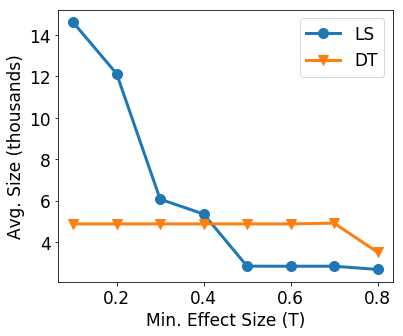

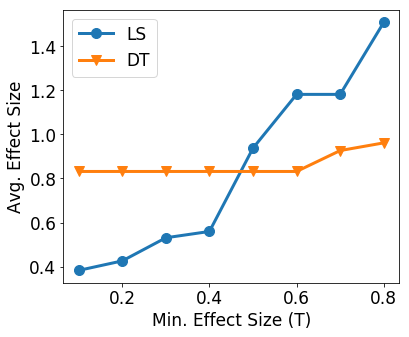

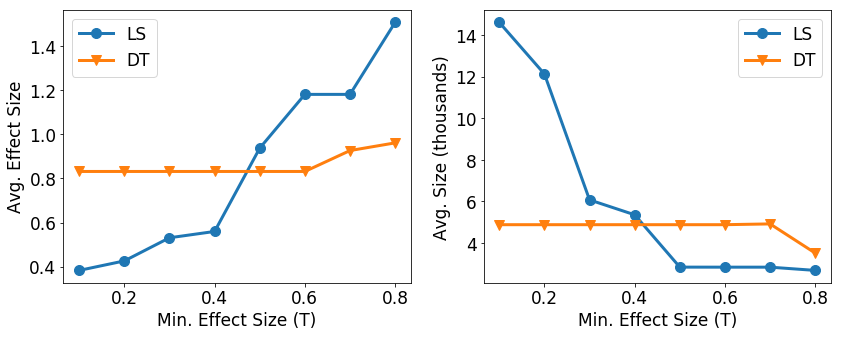

In [149]:
plt.figure(1, figsize=(6,5))
ax = plt.subplot(1,1,1)
plt.plot(sf_k, np.array(sf_avg_sizes)/1000, 'o-', label='LS', linewidth=3.0, markersize=10)
#plt.plot(cluster_k, np.array(cluster_avg_sizes)/1000, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, np.array(tree_avg_sizes)/1000, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Min. Effect Size (T)', fontsize=17)
plt.ylabel('Avg. Size (thousands)', fontsize=17)
plt.savefig('%s_size_%s_2.pdf'%(dataset,min_eff_size))        
        
plt.figure(2, figsize=(6,5))
ax = plt.subplot(1,1,1)
plt.plot(sf_k, sf_avg_eff_sizes, 'o-', label='LS', linewidth=3.0, markersize=10)
#plt.plot(cluster_k, cluster_avg_eff_sizes, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, tree_avg_eff_sizes, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Min. Effect Size (T)', fontsize=17)
plt.ylabel('Avg. Effect Size', fontsize=17)
plt.tight_layout()
plt.savefig('%s_effsize_%s_2.pdf'%(dataset,min_eff_size))
plt.show()

plt.figure(3, figsize=(12,5))
plt.subplot(1,2,2)
plt.plot(sf_k, np.array(sf_avg_sizes)/1000, 'o-', label='LS', linewidth=3.0, markersize=10)
#plt.plot(cluster_k, np.array(cluster_avg_sizes)/1000, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, np.array(tree_avg_sizes)/1000, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Min. Effect Size (T)', fontsize=17)
plt.ylabel('Avg. Size (thousands)', fontsize=17)
plt.subplot(1,2,1)
plt.plot(sf_k, sf_avg_eff_sizes, 'o-', label='LS', linewidth=3.0, markersize=10)
#plt.plot(cluster_k, cluster_avg_eff_sizes, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, tree_avg_eff_sizes, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Min. Effect Size (T)', fontsize=17)
plt.ylabel('Avg. Effect Size', fontsize=17)
#plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.savefig('%s_slider.pdf'%(dataset))
plt.tight_layout()
plt.show()



## Fraudulent Data

In [14]:
import copy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from risk_control import effect_size
from decision_tree import DecisionTree

#main_df=pd.read_csv("creditcard.csv")
main_df=pd.read_csv("data/creditcard.csv")
main_df.head()
feature_size = len(main_df.columns)
class_index = feature_size -1 

fraud_raw = main_df[main_df['Class'] == 1]
normal_raw = main_df[main_df['Class'] == 0]

# Undersample the normal transactions
percentage = len(fraud_raw)/float(len(normal_raw))
normal = normal_raw.sample(frac=percentage)
fraud = fraud_raw
cc_data = fraud.append(normal)

In [5]:
#msk = np.random.rand(len(cc_data)) < 0.8
X, y = cc_data[cc_data.columns.difference(["Class"])], cc_data["Class"]
#X_train, y_train = X[msk], y[msk]
#X, y = X[~msk], y[~msk]

reg_model = RandomForestClassifier(criterion='entropy',n_estimators=100)
lr = reg_model.fit(X,y)

In [6]:
sf = SliceFinder(lr, (X, y))
metrics_all = sf.evaluate_model((X,y))
reference = (np.mean(metrics_all), np.std(metrics_all), len(metrics_all))

In [9]:
recommendations = sf.find_slice(k=30, epsilon=0.4, degree=5)
encoders = {}
for s in recommendations:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('---------------------\nmetric: %s'%(s.metric))
    print ('size: %s'%(s.size))


Slice description:
V17:0.512362754277 ~ 1.17193723459
---------------------
effect_size: 0.730149341476
---------------------
metric: 0.104595746695
size: 99

Slice description:
V18:0.487793259179 ~ 1.01170928247
---------------------
effect_size: 0.45922869468
---------------------
metric: 0.0793451792101
size: 99

Slice description:
V21:-0.100400181768 ~ 0.0137410881749
---------------------
effect_size: 0.427219694911
---------------------
metric: 0.0773811381036
size: 99

Slice description:
V3:-0.643387104927 ~ 0.0259153271539
---------------------
effect_size: 0.452310831997
---------------------
metric: 0.07986624206
size: 99

Slice description:
V3:0.60905131525 ~ 1.20643458984
---------------------
effect_size: 0.471839184916
---------------------
metric: 0.0825898737282
size: 99

Slice description:
V5:0.774036846205 ~ 1.51151331132
---------------------
effect_size: 0.499900215842
---------------------
metric: 0.0816519366196
size: 99

Slice description:
V9:0.45975256166 ~ 1.0

In [12]:
slices, uninteresting = list(), list()
with open('slices.p','rb') as handle:
    slices = pickle.load(handle)
with open('uninteresting.p','rb') as handle:
    uninteresting = pickle.load(handle)  
    
min_eff_size = 0.4
dataset = 'Fraud'

sf_recs = [s for s in slices+uninteresting if s.effect_size >= min_eff_size]
sf_recs = sorted(sf_recs, key=lambda x: x.size, reverse=True)

In [ ]:
filtered_slices, rejected = sf.filter_by_significance(slices, reference, 0.05)
print (len(filtered_slices), len(rejected))

In [11]:
scaler = StandardScaler()
numeric_cols = list(main_df.columns[1:28])
X_ = copy.deepcopy(X)
X_[numeric_cols] = scaler.fit_transform(X_[numeric_cols])
reduced_data_train = PCA(n_components=2).fit_transform(X_)
reduced_data_test = PCA(n_components=2).fit_transform(X_)

NameError: name 'copy' is not defined

In [15]:
decisions = []
for x_, y_ in zip(X.as_matrix(), y.as_matrix()):
    y_p = lr.predict([x_])
    if y_p == y_:
        decisions.append(0)
    else:
        decisions.append(1)
dt = DecisionTree((X, y), lr)
dt = dt.fit(max_depth=20, min_size=10)

test root, size: 984


In [ ]:
sf_k, sf_avg_sizes, sf_avg_eff_sizes = list(), list(), list()
cluster_k, cluster_avg_sizes, cluster_avg_eff_sizes = list(), list(), list()
tree_k, tree_avg_sizes, tree_avg_eff_sizes = list(), list(), list()

for k in range(1, 11):
    sf_recs_ = sf_recs[:k]
    if len(sf_recs_) == k:
        sf_k.append(k)
        sf_avg_sizes.append(np.mean([s.size for s in sf_recs_]))
        sf_avg_eff_sizes.append(np.mean([s.effect_size for s in sf_recs_]))
    
    kmeans = KMeans(init='k-means++', n_clusters=k)
    kmeans.fit(reduced_data_train) # train with mis-classified data
    y_predicted = kmeans.predict(reduced_data_test) # classify all data
    sizes, eff_sizes = list(), list()
    for cluster_id in np.unique(kmeans.labels_):
        X_cluster = X[np.array(y_predicted) == cluster_id]
        y_cluster = y[np.array(y_predicted) == cluster_id]
        sizes.append(len(X_cluster))
        eff_sizes.append(effect_size(sf.evaluate_model((X_cluster, y_cluster)), reference))
    cluster_k.append(k)
    cluster_avg_eff_sizes.append(np.mean(eff_sizes))
    cluster_avg_sizes.append(np.mean(sizes))
    
    dt_recs = dt.recommend_slices(k=k, min_effect_size=min_eff_size)
    if len(dt_recs) == k:
        tree_k.append(k)
        tree_avg_sizes.append(np.mean([s.size for s in dt_recs]))
        tree_avg_eff_sizes.append(np.mean([s.eff_size for s in dt_recs]))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 17})

plt.figure(1, figsize=(6,5))
ax = plt.subplot(1,1,1)
plt.plot(sf_k, np.array(sf_avg_sizes)/100, 'o-', label='LS', linewidth=3.0, markersize=10)
plt.plot(cluster_k, np.array(cluster_avg_sizes)/100, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, np.array(tree_avg_sizes)/100, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Numb. of Recommendations', fontsize=17)
plt.ylabel('Avg. Size (hundreds)', fontsize=17)
plt.savefig('%s_size%s.pdf'%(dataset,min_eff_size))

plt.figure(2, figsize=(6,5))
ax = plt.subplot(1,1,1)
plt.plot(sf_k, sf_avg_eff_sizes, 'o-', label='LS', linewidth=3.0, markersize=10)
plt.plot(cluster_k, cluster_avg_eff_sizes, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, tree_avg_eff_sizes, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Numb. of Recommendations', fontsize=17)
plt.ylabel('Avg. Effect Size', fontsize=17)
plt.tight_layout()
plt.savefig('%s_effsize_%s.pdf'%(dataset,min_eff_size))
plt.show()

plt.figure(3, figsize=(12,5))
#plt.suptitle('Quality of recommended slices from UCI Census Data Set', y=1.02)
plt.subplot(1,2,1)
plt.plot(sf_k, np.array(sf_avg_sizes)/100, 'o-', label='LS', linewidth=3.0, markersize=10)
plt.plot(cluster_k, np.array(cluster_avg_sizes)/100, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, np.array(tree_avg_sizes)/100, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Numb. of Recommendations', fontsize=17)
plt.ylabel('Avg. Size (hundreds)', fontsize=17)
plt.subplot(1,2,2)
plt.plot(sf_k, sf_avg_eff_sizes, 'o-', label='LS', linewidth=3.0, markersize=10)
plt.plot(cluster_k, cluster_avg_eff_sizes, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, tree_avg_eff_sizes, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Numb. of Recommendations', fontsize=17)
plt.ylabel('Avg. Effect Size', fontsize=17)
#plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.tight_layout()
plt.show()

In [16]:

k = 10

sf_k, sf_avg_sizes, sf_avg_eff_sizes = list(), list(), list()
cluster_k, cluster_avg_sizes, cluster_avg_eff_sizes = list(), list(), list()
tree_k, tree_avg_sizes, tree_avg_eff_sizes = list(), list(), list()

for min_eff_size in np.array(range(1,9))/10.:
    sf = SliceFinder(lr, (X, y))
    sf_recs = [s for s in slices+uninteresting if s.effect_size >= min_eff_size]
    sf_recs = sorted(sf_recs, key=lambda x: x.size, reverse=True)
    
    sf_recs_ = sf_recs[:k]
    if len(sf_recs_) == k:
        sf_k.append(min_eff_size)
        sf_avg_sizes.append(np.mean([s.size for s in sf_recs_]))
        sf_avg_eff_sizes.append(np.mean([s.effect_size for s in sf_recs_]))
    
   
    dt_recs = dt.recommend_slices(k=k, min_effect_size=min_eff_size)
    if len(dt_recs) == k:
        tree_k.append(min_eff_size)
        tree_avg_sizes.append(np.mean([s.size for s in dt_recs]))
        tree_avg_eff_sizes.append(np.mean([s.eff_size for s in dt_recs]))





/Users/yeounoh/git/slicefinder/risk_control.py:26: RuntimeWarning: invalid value encountered in double_scalars
  sample_b_mean = (mu*n - np.sum(sample_a))/(n-len(sample_a))


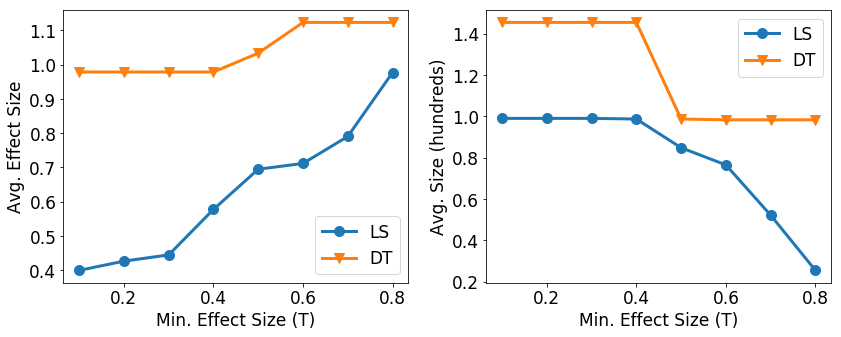

In [19]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 17})

plt.figure(3, figsize=(12,5))
plt.subplot(1,2,2)
plt.plot(sf_k, np.array(sf_avg_sizes)/100, 'o-', label='LS', linewidth=3.0, markersize=10)
#plt.plot(cluster_k, np.array(cluster_avg_sizes)/100, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, np.array(tree_avg_sizes)/100, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Min. Effect Size (T)', fontsize=17)
plt.ylabel('Avg. Size (hundreds)', fontsize=17)
plt.subplot(1,2,1)
plt.plot(sf_k, sf_avg_eff_sizes, 'o-', label='LS', linewidth=3.0, markersize=10)
#plt.plot(cluster_k, cluster_avg_eff_sizes, 's-', label='CL', linewidth=3.0, markersize=10)
plt.plot(tree_k, tree_avg_eff_sizes, 'v-', label='DT', linewidth=3.0, markersize=10)
plt.legend()
plt.xlabel('Min. Effect Size (T)', fontsize=17)
plt.ylabel('Avg. Effect Size', fontsize=17)
#plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.savefig('%s_slider.pdf'%(dataset))
plt.tight_layout()
plt.show()

In [ ]:
### Top-3 slices for LS and DT

In [ ]:
#sf_recs = sorted(sf_recs, key=lambda x: x.size, reverse=True)
for s in sf_recs[:3]:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('---------------------\nmetric: %s'%(s.metric))
    print ('size: %s'%(s.size))
    
for s in dt_recs[:3]:
    print ('\n=====================\nSlice description:')
    print (s.__ancestry__())
    print (s.__str__())
    print ('---------------------\neffect_size: %s'%(s.eff_size))
    print ('size: %s'%(s.size))

# Simulation Study
Emphasize that we are not just accuracy-hungting (i.e., give me slices with lowest performance?? The challenge is automatically defining slices, because there are just so many ways to slice the data); to this end, show how the performance distributions change over differnet numbers of clusters--connect this to the original motiviation, where the overall perofrmance differs from smaller slice performances.

Comment: model accuracy distributions? What happens when we add two additional dimensions, like size and interpretability? We need an interactive tool to assist users to quickly browse through problematic data slices for model validation.

## Feature variance

In [4]:
import seaborn as sns

In [8]:
y_hat = lr.predict(X)
X_mis = X[y != y_hat]

In [9]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = pd.DataFrame(
    min_max_scaler.fit_transform(X_mis.values), 
    columns=X.columns)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

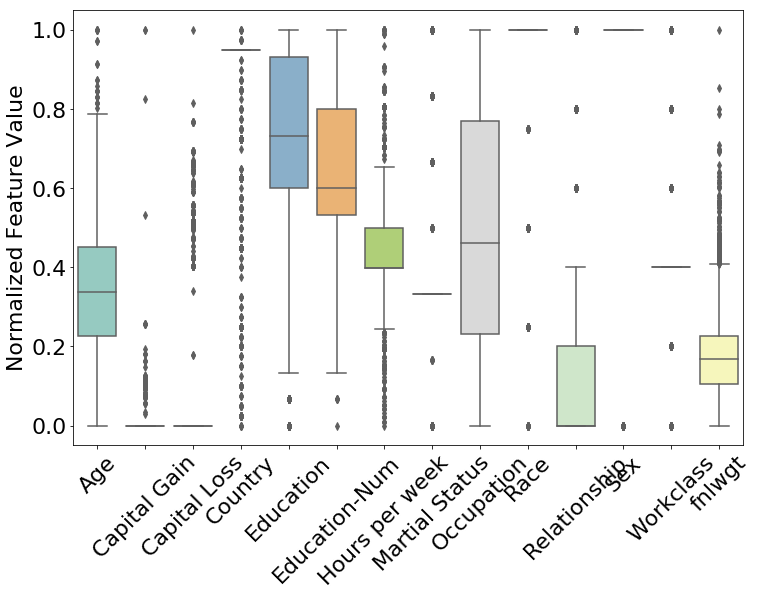

In [49]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12,8))
ax = sns.boxplot(data=X_scaled, palette="Set3")
plt.ylabel('Normalized Feature Value')
plt.xticks(rotation=45)

## Accuracy-hunting approach
If we simply look for data slices with the lowest performance metrics, then we might end up with 1) slices that are too small or 2) too complicated to summarize and manually interpret. This is aside from the fact that we want to avoid presenting a numerous number of data slices to the user; to this end, we propose both a metric to identify a problematic slice for model validation and efficient top-down data slicing strategies that bring user's attention to a handful of the most problematic slices.

In [11]:
adult_data2 = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

# drop nan values
adult_data2 = adult_data2.dropna()
adult_mis = adult_data2[y!=y_hat]
#print(adult_mis.dtypes)
df_edu_sex = pd.crosstab(adult_mis['Education'],adult_mis['Sex'])

#mosaic(df_edu_sex.stack(), title='Education-Sex')
#plt.show()

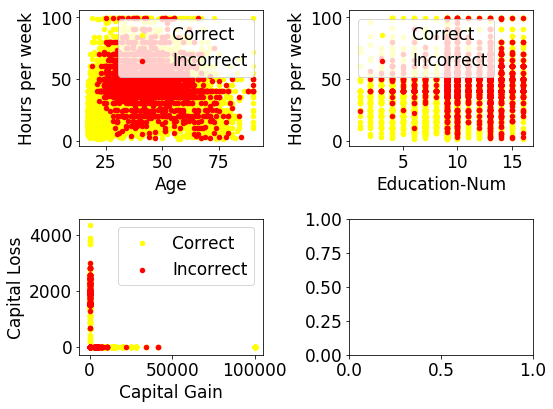

In [14]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
adult_data2.plot.scatter('Age','Hours per week', color='yellow', label='Correct', ax=axes[0][0])
adult_mis.plot.scatter('Age','Hours per week', color='red', label='Incorrect',ax=axes[0][0])

adult_data2.plot.scatter('Education-Num','Hours per week', color='yellow', label='Correct', ax=axes[0][1])
adult_mis.plot.scatter('Education-Num','Hours per week', color='red', label='Incorrect',ax=axes[0][1])

adult_data2.plot.scatter('Capital Gain','Capital Loss', color='yellow', label='Correct', ax=axes[1][0])
adult_mis.plot.scatter('Capital Gain','Capital Loss', color='red', label='Incorrect',ax=axes[1][0])
plt.tight_layout()

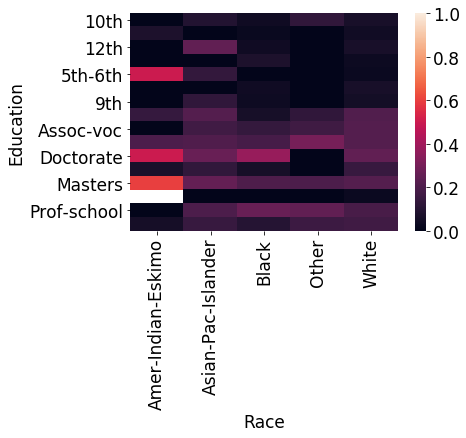

In [15]:
df_edu_race = pd.crosstab(adult_mis['Education'], adult_mis['Race']).divide(
    pd.crosstab(adult_data2['Education'],adult_data2['Race']))
sns.heatmap(df_edu_race, vmin=0, vmax=1)

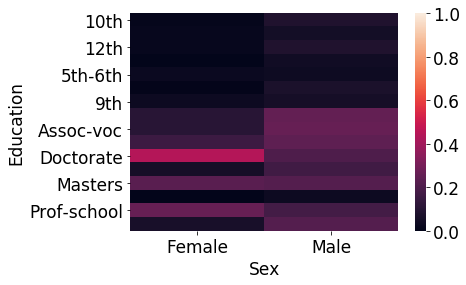

In [16]:
df_edu_sex = pd.crosstab(adult_mis['Education'], adult_mis['Sex']).divide(
    pd.crosstab(adult_data2['Education'],adult_data2['Sex']))
sns.heatmap(df_edu_sex, vmin=0, vmax=1)
plt.savefig('heat_edu_sex.png', bbox_inches='tight')

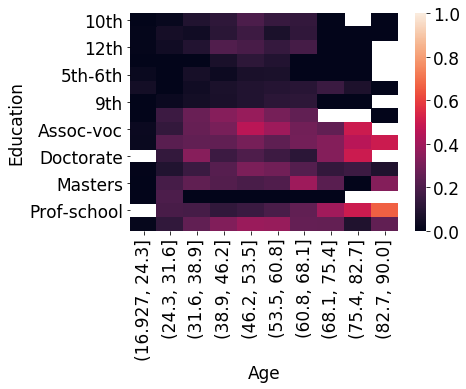

In [17]:
y_male = y[X['Sex']==1]
y_hat_male = lr.predict(X[X['Sex'] == 1])

adult_male = adult_data2[adult_data2['Sex'] == 'Male']
adult_male['Age'] = pd.cut(adult_male.Age, 10)
adult_male_edu_age = pd.crosstab(adult_male['Education'],adult_male['Age'])

adult_male_mis = adult_male[y_male != y_hat_male]
adult_male_mis_edu_age = pd.crosstab(adult_male_mis['Education'],adult_male_mis['Age'])

df_male_edu_age = adult_male_mis_edu_age.divide(adult_male_edu_age)
sns.heatmap(df_male_edu_age, vmin=0, vmax=1)
plt.savefig('heat_male_edu_age.png', bbox_inches='tight')

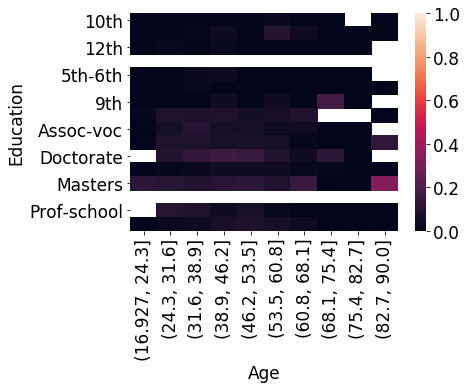

In [134]:
y_female = y[X['Sex']==0]
y_hat_female = lr.predict(X[X['Sex'] == 0])

adult_female = adult_data2[adult_data2['Sex'] == 'Female']
adult_female['Age'] = pd.cut(adult_female.Age, 10)
adult_female_edu_age = pd.crosstab(adult_male['Education'],adult_male['Age'])

adult_female_mis = adult_female[y_female != y_hat_female]
adult_female_mis_edu_age = pd.crosstab(adult_female_mis['Education'],adult_female_mis['Age'])

df_female_edu_age = adult_female_mis_edu_age.divide(adult_female_edu_age)
sns.heatmap(df_female_edu_age, vmin=0, vmax=1)
plt.savefig('heat_female_edu_age.png', bbox_inches='tight')

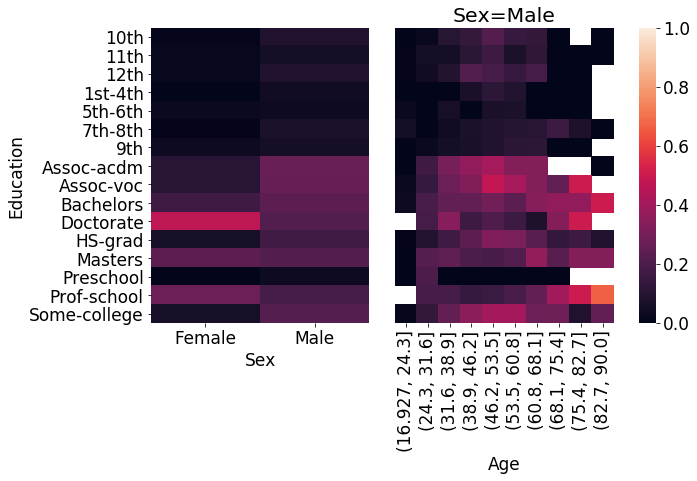

In [167]:
fig, axes = plt.subplots(1,3,figsize=(10,7),gridspec_kw={'width_ratios':[1,1,0.08]})
g1 = sns.heatmap(df_edu_sex, vmin=0, vmax=1, cbar=False, ax=axes[0])
g2 = sns.heatmap(df_male_edu_age, vmin=0, vmax=1, ax=axes[1], cbar_ax=axes[2])
g2.set_ylabel('')
g2.set_yticks([])
g2.set_title('Sex=Male')
#g3 = sns.heatmap(df_female_edu_age, vmin=0, vmax=1, ax=axes[2], cbar_ax=axes[3])
#g3.set_ylabel('')
#g3.set_yticks([])
#plt.xticks(rotation=75)
plt.tight_layout()
plt.savefig('heat_male_edu_age2.png', bbox_inches='tight')

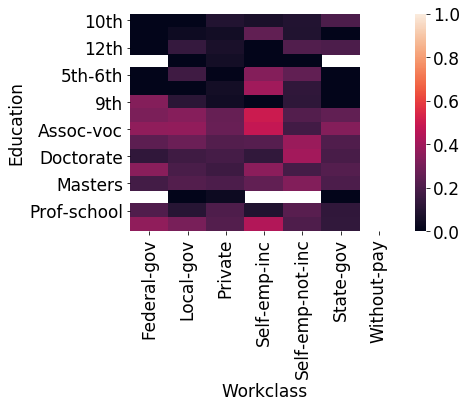

In [171]:
y_male = y[X['Sex']==1]
y_hat_male = lr.predict(X[X['Sex'] == 1])

adult_male = adult_data2[adult_data2['Sex'] == 'Male']
adult_male_edu_work = pd.crosstab(adult_male['Education'],adult_male['Workclass'])

adult_male_mis = adult_male[y_male != y_hat_male]
adult_male_mis_edu_work = pd.crosstab(adult_male_mis['Education'],adult_male_mis['Workclass'])

df_male_edu_work = adult_male_mis_edu_work.divide(adult_male_edu_work)
sns.heatmap(df_male_edu_work, vmin=0, vmax=1)
plt.savefig('heat_male_edu_work.png', bbox_inches='tight')

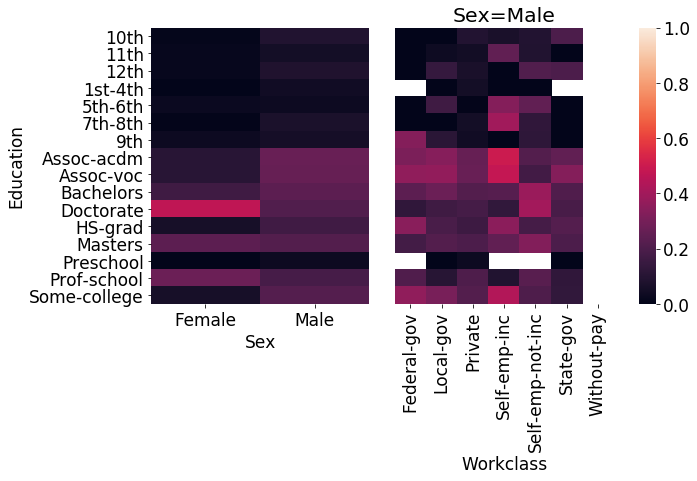

In [172]:
fig, axes = plt.subplots(1,3,figsize=(10,7),gridspec_kw={'width_ratios':[1,1,0.08]})
g1 = sns.heatmap(df_edu_sex, vmin=0, vmax=1, cbar=False, ax=axes[0])
g2 = sns.heatmap(df_male_edu_work, vmin=0, vmax=1, ax=axes[1], cbar_ax=axes[2])
g2.set_ylabel('')
g2.set_yticks([])
g2.set_title('Sex=Male')
#g3 = sns.heatmap(df_female_edu_age, vmin=0, vmax=1, ax=axes[2], cbar_ax=axes[3])
#g3.set_ylabel('')
#g3.set_yticks([])
#plt.xticks(rotation=75)
plt.tight_layout()
plt.savefig('heat_male_edu_work2.png', bbox_inches='tight')

## Recall of Injected Ground Truth
Compare the effectiveness of different search strategies based on recall and the injected ground truth.

### Ground Truth Injection

In [69]:
adult_data = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

# drop nan values
adult_data = adult_data.dropna()

# Encode categorical features
encoders = {}
for column in adult_data.columns:
    if adult_data.dtypes[column] == np.object:
        le = LabelEncoder()
        adult_data[column] = le.fit_transform(adult_data[column])
        encoders[column] = le

# Original dataset (X, y)
X, y = adult_data[adult_data.columns.difference(["Target"])], adult_data["Target"]

In [76]:
unmarried_white = X[(X['Relationship']==4) & (X['Race']==4)]
unmarried_white_female = unmarried_white[unmarried_white['Sex']==0]
print('Original dataset size: %s'%len(X))
print('Unmarried white demographic size: %s'%len(unmarried_white))
print('Unmarried white female demographic size: %s'%len(unmarried_white_female))

# Corrupted labels
import copy
y_c = copy.copy(y)
y_c.loc[unmarried_white_female.index] = (y_c.loc[unmarried_white_female.index] + 1)%2

Original dataset size: 30162
Unmarried white demographic size: 2341
Unmarried white female demographic size: 1732


In [77]:
# Train a model
lr_c = RandomForestClassifier(max_depth=5, n_estimators=10)
lr_c.fit(X, y_c)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [78]:
# Instantiate Slice Finder
sf = SliceFinder(lr_c, (X, y))
metrics_all = sf.evaluate_model((X,y))
reference = (np.mean(metrics_all), np.std(metrics_all), len(metrics_all))

## Multiple-Comparison Problem

In [4]:
dataset = 'UCI'
encoders = {}

main_df = pd.read_csv("data/creditcard.csv")
main_df = main_df.dropna()
main_df.head()
feature_size = len(main_df.columns)
class_index = feature_size -1 

fraud_raw = main_df[main_df['Class'] == 1]
normal_raw = main_df[main_df['Class'] == 0]

# Undersample the normal transactions
percentage = len(fraud_raw)/float(len(normal_raw))
normal = normal_raw.sample(frac=percentage)
fraud = fraud_raw
cc_data = fraud.append(normal)

X, y = cc_data[cc_data.columns.difference(["Class"])], cc_data["Class"]

reg_model = RandomForestClassifier(criterion='entropy',n_estimators=100)
lr = reg_model.fit(X,y)

In [5]:
sf = SliceFinder(lr, (X, y))
metrics_all = sf.evaluate_model((X,y))
reference = (np.mean(metrics_all), np.std(metrics_all), len(metrics_all))

In [8]:
adult_data = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

# drop nan values
adult_data = adult_data.dropna()

# Encode categorical features
encoders = {}
for column in adult_data.columns:
    if adult_data.dtypes[column] == np.object:
        le = LabelEncoder()
        adult_data[column] = le.fit_transform(adult_data[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X, y = adult_data[adult_data.columns.difference(["Target"])], adult_data["Target"]

# Train a model
#lr = LogisticRegression()
#lr.fit(X, y)
lr = RandomForestClassifier(max_depth=5, n_estimators=10)
lr.fit(X, y)

sf = SliceFinder(lr, (X, y))
metrics_all = sf.evaluate_model((X,y))
reference = (np.mean(metrics_all), np.std(metrics_all), len(metrics_all))

Workclass ['Federal-gov' 'Local-gov' 'Private' 'Self-emp-inc' 'Self-emp-not-inc'
 'State-gov' 'Without-pay'] [0 1 2 3 4 5 6]
Education ['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Martial Status ['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed'] [0 1 2 3 4 5 6]
Occupation ['Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-specialty' 'Protective-serv' 'Sales'
 'Tech-support' 'Transport-moving'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Relationship ['Husband' 'Not-in-family' 'Other-relative' 'Own-child' 'Unmarried' 'Wife'] [0 1 2 3 4 5]
Race ['Amer-Indian-Eskimo' 'Asian-Pac-Islander' 'Black' 'Other' 'White'] [0 1 2 3 4]
Sex ['Female' 'M

In [ ]:
recommendations = sf.find_slice(k=100, epsilon=0.4, degree=3, risk_control=False)
slices, uninteresting = list(), list()

degree 1
crossing
done
effect size filtering
done
degree 2
crossing
done
effect size filtering


KeyboardInterrupt: 

Process Process-2:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


In [9]:
# slice finder results before risk control
with open('slices.p','rb') as handle:
    slices = pickle.load(handle)
with open('uninteresting.p', 'rb') as handle:
    uninteresting = pickle.load(handle) 

print(len(slices))    
    
slices, rejected, bf_slices, bf_rejected, ai_slices, ai_rejected = sf.filter_by_significance(
    slices, reference, 0.1, max_workers=10)
print('\n============t-Testing:')
'''
for s in rejected:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('---------------------\nmetric: %s'%(s.metric))
    print ('size: %s'%(s.size))
'''
with open('accepted_%s.p'%dataset,'wb') as handle:
    pickle.dump(slices, handle)
with open('rejected_%s.p'%dataset, 'wb') as handle:
    pickle.dump(rejected, handle)
    
print('\n============Bon Ferroni:')
'''
for s in bf_rejected:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('---------------------\nmetric: %s'%(s.metric))
    print ('size: %s'%(s.size))
'''
with open('bf_accepted_%s.p'%dataset,'wb') as handle:
    pickle.dump(bf_slices, handle)
with open('bf_rejected_%s.p'%dataset, 'wb') as handle:
    pickle.dump(bf_rejected, handle)   
    
print('\n============Alpha-Investing:')
'''
for s in ai_rejected:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('---------------------\nmetric: %s'%(s.metric))
    print ('size: %s'%(s.size))
'''
with open('ai_accepted_%s.p'%dataset,'wb') as handle:
    pickle.dump(ai_slices, handle)
with open('ai_rejected_%s.p'%dataset, 'wb') as handle:
    pickle.dump(ai_rejected, handle) 


39358

============t-Testing:

============Bon Ferroni:

============Alpha-Investing:


In [ ]:
#print (len(slices), len(rejected)) # fraud (1544, 4182), census (2530, 876)
#print (np.mean([s.size for s in slices]), np.mean([s.size for s in rejected])) # fraud (7.86, 8.36), census (44.19, 5.18)
#print (np.mean([s.effect_size for s in slices]), np.mean([s.effect_size for s in rejected])) # fraud (1.54, 0.60), census (1.28, 0.65)       

In [10]:
print(len(rejected), len(slices))
print(len(bf_rejected), len(bf_slices))
print(len(ai_rejected), len(ai_slices))

dataset='fraud'
with open('accepted_%s.p'%dataset,'rb') as handle:
    slices = pickle.load(handle)
with open('rejected_%s.p'%dataset, 'rb') as handle:
    rejected = pickle.load(handle)
with open('bf_accepted_%s.p'%dataset,'rb') as handle:
    bf_slices = pickle.load(handle)
with open('bf_rejected_%s.p'%dataset, 'rb') as handle:
    bf_rejected = pickle.load(handle)
with open('ai_accepted_%s.p'%dataset,'rb') as handle:
    ai_slices = pickle.load(handle)
with open('ai_rejected_%s.p'%dataset, 'rb') as handle:
    ai_rejected = pickle.load(handle)

    
plt.figure(1, figsize=(6,5))
significant = [s.size for s in slices if s.size]
insignificant = [s.size for s in rejected if s.size]
bins = np.linspace(0, max(significant), 50)
plt.hist(significant, bins, alpha=0.5, label='Accepted')
plt.hist(insignificant, bins, alpha=0.5, label='Rejected')
plt.xlim([0,100])
plt.legend(loc='upper right')
plt.xlabel('Slice Size',fontsize=17)
plt.tight_layout()
#plt.savefig('figures/longtail_%s.pdf'%dataset)

plt.figure(2, figsize=(6,5))
significant = [s.size for s in slices if s.size]
bf_significant = [s.size for s in bf_slices if s.size]
ai_significant = [s.size for s in ai_slices if s.size]
#insignificant = [s.size for s in rejected if s.size]
bins = np.linspace(0, max(significant), 50)
bf_bins = np.linspace(0, max(bf_significant), 50)
ai_bins = np.linspace(0, max(ai_significant), 50)
plt.hist(significant, bins, alpha=0.5, label='t-Testing')
plt.hist(bf_significant, bf_bins, alpha=0.5, label='Bon Ferroni')
plt.hist(ai_significant, ai_bins, alpha=0.5, label='Alpha-Investing')
#plt.hist(insignificant, bins, alpha=0.5, label='Rejected')
plt.xlim([0,100])
plt.legend(loc='upper right')
plt.xlabel('Slice Size',fontsize=17)
plt.tight_layout()
#plt.savefig('figures/longtail_%s.pdf'%dataset)


39358 0
39358 0
39358 0


ValueError: max() arg is an empty sequence